**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1) Load the dataset and perform splitting into training and validation sets with 70:30 ratio.

> Do we need to normalise data? [If so Does it make any difference?]

2) Implement the K Means algorithm. You need to find the optimal number of clusters using the
    elbow method and silhouette method. 

3) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

4) Experiment with different distance measures[Euclidean distance, Manhattan distance].

5) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.

6) Report the training and the validation accuracy and Compare your trained model with a model trained by the scikit-learn

7) Visualize the dataset to depict the clusters formed. #Prefer T-SNE

8) Implement K-means++, and repeat task 1 to task 7 again.</br>
</br>
</br>
</br>
</br>
**Part 2:**
</br>
In this task, you will perform operations on `[data.csv](https://drive.google.com/file/d/15NPkfXFoTkiRBlcI4ffe_Lp_BFOyf8UY/view?usp=sharing)`, data.csv is a  latent space representation of  Fashion-MNIST, before doing this task please read about latent space representation.

9) Load the data.csv file and apply Kmeans and Kmeans++, You need to find the optimal number of clusters using the elbow method and silhouette method.

10) Visualize the dataset to depict the clusters formed. # Prefer T-SNE

11) From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?
</br>
</br>
**Note:** If the model takes a lot of time to train you can use MiniBatchKMeans.
 




### Importing required libraries

In [29]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import homogeneity_score
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import timeit
import random
import sys
import pprint
import copy
import seaborn as sns

### Elbow method

In [ ]:
#implement elbow method from scratch
def elbow(X_train, y_train, start, end, algo="kmeans"):
  costs = []
  for i in range(start, end):
    print(i)
    if (algo=="kmeans"):
      kmeans = Kmeans(i, init="Random partition", max_iter=100)
      kmeans.fit(X_train, y_train)
      costs.append(kmeans.cost())
    else:
      kmeanspp = Kmeansplusplus(i)
      
    print("--------------------------------------")
  return costs

### Silhouette method 
### This function works properly, but on running it for values of K in a range, colab would have session out every time. So, could not display results of it.

In [11]:
def  compute_distances(X_test, X_train): 
  X_test_sq = np.sum((X_test**2),axis=1)[:, np.newaxis]
  X_train_sq = np.sum((X_train**2),axis=1)
  x = np.dot(X_test, X_train.T)
  dist = np.sqrt(X_test_sq + X_train_sq - 2*x)
  return dist


def silhouette(X, clusters):
  silhoutte_vals = np.zeros(X.shape[0])
  tot_sil_vals = 0.0
  n_clusters = len(clusters)
  print(n_clusters)
  center_idx = []
  for C in clusters:
    center_idx.append(C[0])
  print(center_idx)
  centroids = X[center_idx] 
  print(centroids.shape)
  inter_cluster_dist = compute_distances(centroids,centroids)
  np.fill_diagonal(inter_cluster_dist, np.inf)
  closest_cluster_idx = np.argmin(inter_cluster_dist, axis=1)

  for k in range(n_clusters):
    print("cluster ",k)
    my_cluster = X[clusters[k][1]]
    #print(my_cluster.shape)
    dist = compute_distances(my_cluster, my_cluster)
    #print(dist.shape)
    
    mean_dist_in_cluster = np.mean(dist, axis=1)
    #print("mean_dist_in_cluster",mean_dist_in_cluster.shape)
    closest_cluster = X[ clusters[closest_cluster_idx[k]][1] ]
    #print(closest_cluster.shape)
    
    dist = compute_distances(my_cluster, closest_cluster)
    #print(dist.shape)
    #break
    mean_dist_other_cluster = np.mean(dist, axis=1)
    print("mean_dist_other_cluster",mean_dist_other_cluster.shape, "mean_dist_in_cluster",mean_dist_in_cluster.shape)
    tmp =np.zeros((2,mean_dist_in_cluster.shape[0]))
    tmp[0] = mean_dist_in_cluster
    tmp[1] = mean_dist_other_cluster
    #print("tmmp",tmp.shape)
    sil_vals = (mean_dist_in_cluster - mean_dist_other_cluster)/np.amax(tmp,axis=0)
    print("sil_vals",sil_vals.shape)
    silhoutte_vals[clusters[k][1]] = sil_vals
    tot_sil_vals += np.sum(sil_vals)/mean_dist_in_cluster.shape[0]
    #break
  avg_sil_val = tot_sil_vals/len(clusters)
  return silhoutte_vals, avg_sil_val

## KMEANS CLASS

In [4]:
#implement Kmeans from scratch

class Kmeans():
    def __init__(self, n_clusters = 3, init="forgy", metric="euc", random_state = 0, max_iter=300, tol=0.0001):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        self.init_type = init
        self.y = []
        self.metric = metric

    def forgy_initialization(self, data):
        temp = random.sample(range(data.shape[0]),self.n_clusters)
        for i in range(len(temp)):
            self.centers[i] = data[temp[i]]

    def Random_Partition_initialization(self, data):
        indices = np.array(list(range(data.shape[0])))
        np.random.shuffle(indices)
        partitions = np.array_split(indices, self.n_clusters)
        for i in range(self.n_clusters):
            tmp = data[partitions[i]]
            avg = np.mean(tmp, axis=0)
            self.centers[i] = avg
            
          
    def initialize_cluster_centroids(self, data):
        if (self.init_type == "forgy"):
            self.forgy_initialization(data)
        elif (self.init_type == "Random partition"):
            self.Random_Partition_initialization(data)
        else:
            print("INVALID INITIALIZATION TYPE")  
            sys.exit()

    def silhouette(self):
        silhoutte_vals = np.zeros(self.X.shape[0])
        for i in range(self.n_clusters):
            idx = self.indexes[i]
            tot_inter_cluster_dist = 0.0
            for id in idx:
                # Get average inter-cluster distance
                tot_inter_cluster_dist += np.sqrt(np.sum((self.X[id] - self.X[idx])**2, axis=1))
                avg_inter_cluster_dist = np.sum(tot_inter_cluster_dist) / len(self.indexes[i])

                # Get average closest-cluster distance
                dist_with_clusters = []
                for k in self.centers.keys():
                    dist_with_clusters.append(np.sum((self.X[id] - self.centers[k])**2))
                #dist_with_clusters = np.sum((self.X[id] - self.centers)**2, axis=1)
                dist_with_clusters = np.array(dist_with_clusters)
                closest_cluster = np.argpartition(dist_with_clusters, 2)[1]
                tot_intra_cluster_dist = np.sqrt(np.sum((self.X[id] - self.X[self.indexes[closest_cluster]])**2, axis=1))
                avg_intra_cluster_dist = np.sum(tot_intra_cluster_dist) / len(self.indexes[closest_cluster])

                sil_val = (avg_intra_cluster_dist - avg_inter_cluster_dist)/max(avg_intra_cluster_dist , avg_inter_cluster_dist)
                silhoutte_vals[id] = sil_val
                
        return silhoutte_vals

    def fit(self, data, y):
        self.X = data
        self.y = y
        self.centers = {}
        self.initialize_cluster_centroids(self.X)
        for i in range(self.max_iter):
            self.classes = {}
            self.indexes = {}
            prev_centers = dict(self.centers)
            for t in range(self.n_clusters):
                self.classes[t] = []
                self.indexes[t] = []
            start = 0
            for row in self.X:
                if (self.metric=="euc"): 
                    dists = [np.linalg.norm(row-self.centers[c]) for c in self.centers]
                else:
                    dists =  [np.sum((abs(row-self.centers[c]))) for c in self.centers]
                index = dists.index(min(dists))
                self.classes[index].append(row)
                self.indexes[index].append(start)
                start += 1
            for t in range(len(self.centers)):
                self.centers[t] = np.average(self.classes[t], axis = 0)
            flag = True
            error = 0.00
            for t in range(len(self.centers)):
                e = np.linalg.norm(prev_centers[t]-self.centers[t])
                error += e
                if(e > self.tol):
                    flag = False
            print("Iteration: {0}".format(i))
            print("Error: {0}".format(float(error)))
            if(flag):
                break
        self.labels_ = {}
        for t in range(self.n_clusters):
            lst = list(self.y[self.indexes[t]])
            self.labels_[t] = max(set(lst), key=lst.count)

    def get_purity_per_cluster(self):
        self.purity = {}
        self.total_cost = 0
        for i in range(self.n_clusters):
            tmp = self.y[self.indexes[i]]
            unique, counts = np.unique(tmp, return_counts=True)
            freq = np.asarray((unique, counts)).T
            print(freq)
            id = np.argmax(freq[:,1])
            self.purity[i] = freq[id][1]/np.sum(freq[:,1])
        pprint.pprint(self.purity)
    
    def get_clusters(self):
      return self.indexes, self.centers

    def cost(self):
        tot_err = 0
        for i in self.classes.keys():
          dist = np.sqrt(np.sum((self.X[self.indexes[i]] - self.centers[i])**2, axis=1 ))
          tot_err += np.sum(dist)
        return tot_err

    def check(self):
      print(type(self.classes))
      for k in self.classes.keys():
        print(k, type(self.classes[k]),len(self.classes[k]))
        print(self.classes[k])
    
    def predict_row(self, row):
        dists = [np.linalg.norm(row-self.centers[c]) for c in self.centers]
        index = dists.index(min(dists))
        return index
        
    def predict(self, data):
        res = []
        for row in data:
            res.append(self.predict_row(row))
        return np.array(res)
  

## KMEANS++ CLASS

In [3]:
#implement Kmeans++ from scratch
class Kmeansplusplus:

  def __init__(self, K=5 ):
      self.k = K
  
  '''
  idx 0 - min distances till prev itr 
  idx 1 - curr itr min dist / tot
  idx 2 - class
  idx 3 - indices
  '''

  def display_cluster_info(self):
      print(self.min_dist)
      self.clusters = {}
      #for i in range(self.k):
      k = 1
      for i in self.centroids.keys():
          self.clusters[self.centroids[i][0]] = self.min_dist[self.min_dist[:,2]==self.centroids[i][0]][:,-1] 
          #print(self.centroids[i][0], self.min_dist[:,2]==i, self.min_dist[self.min_dist[:,2]==i][:,-1])
          print(self.centroids[i][0], len(self.clusters[self.centroids[i][0]])) 
          k += 1
      pprint.pprint(self.clusters)

  def fit(self, X):
      self.X = X
      all_idx = np.arange(0,X.shape[0])
      #idx = random.randint(0,X.shape[0])
      self.centroids = {}
      #self.centroids[0] = [idx, X[idx]]
      self.indices = np.ones(X.shape[0], dtype=bool)
      #centre = np.random.randint(0,X.shape[0])
      #centre = idx
      #self.indices[centre] = False
      self.min_dist = np.zeros((X.shape[0],4))
      self.min_dist[:,0] = self.min_dist[:,0] + np.inf
      self.min_dist[:,2] = self.min_dist[:,0] + np.inf
      #min_dist[centre][0] = 0
      self.min_dist[:,3] = all_idx
      for i in range(self.k):
          #print(i)
          if (i==0):
              centre = random.randint(0,X.shape[0]-1)
          self.centroids[i] = [centre, X[centre]]
          self.min_dist[centre][0] = 0
          self.min_dist[centre][2]=centre
          # make current cetroid as false so that it is not selected for random sampling
          self.indices[centre] = False
          # insert new centroid with all other centroids
          self.centroids[i] = [centre, X[centre]]
          cum_prob = np.zeros((X.shape[0]-i-1,2))
          # calculate distance of all points with current centroid
          dist = np.sum((X - self.centroids[i][1])**2, axis=1)
          # get minimum distance of a point with all centroids
          # BUT HOW DO WE KNOW WHICH CENTROID-DIST WAS MIN - ITS INDEX??  
          self.min_dist[:,1] = np.minimum(self.min_dist[:,0] , dist)
          # true - prev centroid was closer - let these be as it is
          # false - new centroid is closer - so update these indices
          closest_centroid = self.min_dist[:,1] < self.min_dist[:,0] 
          self.min_dist[all_idx[closest_centroid],2] = centre

          # RANDOM SAMPLING TO GET THE NEXT CENTROID
          tmp = self.min_dist[self.indices][:,1]
          cum_prob[:,0] = tmp
          cum_prob[:,1] = all_idx[self.indices]
          cum_prob[:,0] /= np.sum(cum_prob[:,0])
          cum_prob[:,0] = np.cumsum(cum_prob[:,0])
          rand_val = random.uniform(0, 1)
          new_centre_idx = np.where(cum_prob[:,0] <= rand_val) 
          
          if (len(new_centre_idx[0])==0):
              new_centre_idx = 0
              centre = int(cum_prob[0][1])
          else:
              new_centre_idx = new_centre_idx[-1]
              centre = int(cum_prob[new_centre_idx[-1]][1])
          self.min_dist[:,0] = self.min_dist[:,1]
         
  def cost(self):
    tot_err = 0
    centroids_idx = list(self.min_dist[:,-2].astype('int'))
    err = np.sqrt(np.sum((self.X - self.X[centroids_idx])**2, axis=1))
    #print(self.X[centroids_idx].shape)
    tot_err = np.sum(err)
    return tot_err

  def get_clusters(self):
      cluster_info = []
      k = 1
      for i in self.centroids.keys():
        cluster_info.append([self.centroids[i][0], list(self.min_dist[self.min_dist[:,2]==self.centroids[i][0]][:,-1].astype(int)) ])
        #self.clusters[self.centroids[i][0]] = list(self.min_dist[self.min_dist[:,2]==self.centroids[i][0]][:,-1].astype(int)) 
        k += 1
      #return self.clusters
      return cluster_info

### Reading data

In [ ]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [ ]:
trainX_flattened = trainX.reshape(len(trainX), 28*28)
testX_flattened = testX.reshape(len(testX), 28*28)
print(trainX_flattened.shape)
print(testX_flattened.shape)
X_train, X_valid, y_train, y_valid = train_test_split(trainX_flattened, trainy, test_size=0.3)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(60000, 784)
(10000, 784)
(42000, 784) (18000, 784) (42000,) (18000,)


### values for elbow method were calculated in parts to avoid colab getting session out

In [ ]:
costs = elbow(X_train, y_train, 2, 11)

In [ ]:
costs2 = elbow(X_train, y_train, 11, 22)

In [ ]:
costs.append(costs2[0])
costs

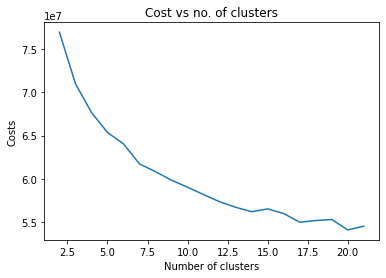

In [ ]:
all_costs = costs + costs2
costs = all_costs
#print(costs)
k = list(range(2,22))
plt.plot(k,costs) 
  
plt.xlabel('Number of clusters') 
plt.ylabel('Costs') 
plt.title('Cost vs no. of clusters') 
plt.show()


### Kmeans for K = 10

In [ ]:
kmeans = Kmeans(10, init="forgy", max_iter=100)
kmeans.fit(X_train, y_train)
pred_labels = kmeans.predict(X_valid)
#print(pred_labels)
#print(y_valid)
print("homogeneity_score = ",homogeneity_score(y_valid,pred_labels ))

Iteration: 0
Error: 16260.294798507424
Iteration: 1
Error: 4804.662816298479
Iteration: 2
Error: 1860.405554329443
Iteration: 3
Error: 1004.4689953734992
Iteration: 4
Error: 644.3048770277135
Iteration: 5
Error: 530.5760592006152
Iteration: 6
Error: 467.9468932835378
Iteration: 7
Error: 394.1460854391801
Iteration: 8
Error: 331.0047095680001
Iteration: 9
Error: 313.4914207621945
Iteration: 10
Error: 270.4054454354842
Iteration: 11
Error: 224.90297193082318
Iteration: 12
Error: 174.78653240791192
Iteration: 13
Error: 155.4126039663411
Iteration: 14
Error: 142.77862193671547
Iteration: 15
Error: 132.9769586784935
Iteration: 16
Error: 131.0800209064008
Iteration: 17
Error: 120.11886269659445
Iteration: 18
Error: 99.84316945087271
Iteration: 19
Error: 87.16421558886057
Iteration: 20
Error: 71.0556636289166
Iteration: 21
Error: 63.23784683703741
Iteration: 22
Error: 59.75639587992975
Iteration: 23
Error: 55.5129522581922
Iteration: 24
Error: 42.297985460627324
Iteration: 25
Error: 38.232119

### homogeneity_score for K=10 using kmeans

In [ ]:
print("homogeneity_score = ",homogeneity_score(y_valid,pred_labels ))

homogeneity_score =  0.49532394256507856


In [ ]:
kmeans2 = Kmeans(10, init="forgy", max_iter=100)
kmeans2.fit(X_train, y_train)
indices, centroids = kmeans2.get_clusters()

### KMEANS++ for K=10 clustering

In [ ]:
kmeanspp = Kmeansplusplus(10)
kmeanspp.fit(X_train)

In [ ]:
#kmeanspp.display_cluster_info()
#kmeanspp.cost()
costs = []
for i in range(2,50):
  kmeanspp = Kmeansplusplus(i)
  kmeanspp.fit(X_train)
  costs.append(kmeanspp.cost())


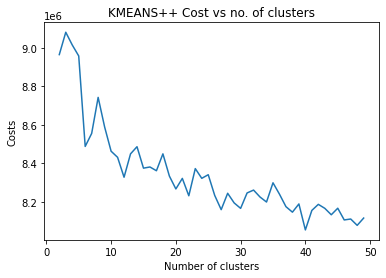

In [ ]:
k = list(range(2,50))
plt.plot(k,costs) 
  
plt.xlabel('Number of clusters') 
plt.ylabel('Costs') 
plt.title('KMEANS++ Cost vs no. of clusters') 
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 2 - Latent Space Representation

In [36]:
df = pd.read_csv('/content/drive/My Drive/SMAI/data.csv')
df.sample(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,class
44521,[6.378805637359619,4.602012,4.000388,3.350867,6.395921,5.293927,3.979218,3.365644,6.115116,5.309839,3.751796,3.215595,5.862191,4.855098,3.646732,3.182768,0.909789,0.873878,0.875598,0.209830,0.237865,0.528777,0.562911,0.000000,0.888939,0.856811,0.795064,0.620990,1.054165,0.912280,1.026320,0.899368,3.237698,1.878253,1.460008,2.371277,3.472999,1.925515,1.889724,2.822264,...,2.259796,2.824838,3.474886,1.937752,2.008841,2.674743,2.990411,4.522880,5.623776,5.948249,5.299212,4.865201,5.498145,5.939679,5.186194,5.309522,5.634641,5.974618,5.059158,5.653883,5.923934,6.015847,5.107884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0],Pullover
19136,[2.767941474914551,0.264472,1.086911,2.249901,4.155739,1.427438,2.267949,3.181172,4.386960,2.796293,2.841831,3.813492,4.876480,3.416862,3.443496,3.728289,2.002970,1.315052,1.564256,2.214080,2.212580,2.991690,3.567080,3.605259,1.841779,2.879567,3.337063,3.185051,0.993967,1.330081,1.369030,1.148875,1.729354,1.407562,1.169722,1.513104,1.315164,0.207416,0.297868,0.874818,...,2.841317,1.765143,0.867925,2.171590,2.027236,1.890127,1.850962,2.058355,1.718808,1.140152,2.368091,4.215839,3.618945,3.298660,3.883122,5.224153,4.892538,4.682278,5.077553,5.554286,5.688754,5.676038,5.775757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0],Bag
27256,[5.528305530548096,3.703179,3.224936,2.929049,5.789514,3.185427,3.198479,3.204909,5.861622,3.206327,3.177293,3.234259,5.937777,3.389948,3.092171,3.212144,1.563057,0.885394,0.877939,0.781175,1.187556,0.842996,0.900198,0.672040,0.850824,0.743448,0.856250,0.670293,0.637434,0.791743,0.865585,0.691539,1.632796,0.992270,0.648548,1.008502,1.608698,0.768100,0.451746,1.025359,...,2.108763,1.658629,3.017210,2.234504,2.113603,1.722558,2.556135,4.227669,5.339403,5.148268,4.864683,4.741856,5.346541,5.213101,5.121290,5.142188,5.138844,5.219311,5.179090,5.377432,5.194924,5.202317,5.147519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0],Shirt
26561,[1.2303141355514526,3.389875,2.242037,0.201702,1.208502,3.394457,2.062393,0.328262,1.436366,3.302558,1.912258,0.537147,1.822051,2.923176,1.717239,0.666946,0.718084,0.720111,0.217976,0.206531,0.727786,0.736435,0.232192,0.300899,0.690179,0.571887,0.117756,0.195008,0.659663,0.506413,0.064150,0.250921,0.615967,1.147058,1.253816,0.746849,0.700842,1.202664,0.931982,0.640740,...,0.792487,2.443936,2.296334,0.000000,0.869278,2.121615,2.553160,1.361971,2.000804,2.826727,1.494804,1.423659,2.046015,2.912534,1.495903,1.512347,2.342609,2.758733,1.606151,1.584707,2.509309,2.846295,1.911018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0],Dress
23299,[3.4353249073028564,2.734158,2.295429,1.955674,3.117516,3.070449,1.904002,1.566752,3.065975,3.618937,1.754036,1.216746,3.208047,3.841134,1.962931,1.097691,1.050858,0.689546,0.451428,0.620559,0.000000,0.368203,0.468099,0.040576,0.367165,0.542009,0.556497,0.023544,0.600490,0.761583,0.722678,0.353901,1.365609,0.889273,0.750358,1.043360,1.727277,1.130162,0.440509,1.216815,...,1.478415,1.549689,2.570888,0.303619,1.495360,1.853691,3.003424,2.937090,3.464384,3.610271,3.211093,2.796137,3.372654,3.387363,2.810724,2.450600,3.384411,3.298529,2.538091,2.311315,3.552366,3.507560,2.573521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0],T-Shirt


In [ ]:
df['class'].unique()

array([' Ankle Boot', ' T-Shirt', ' Dress', ' Pullover', ' Sneaker',
       ' Sandal', ' Trouser', ' Shirt', ' Coat', ' Bag'], dtype=object)

In [37]:
df['class'].replace({' Ankle Boot':1, ' T-Shirt':2, ' Dress':3, ' Pullover':4, ' Sneaker':5,
       ' Sandal':6, ' Trouser':7, ' Shirt':8, ' Coat':9, ' Bag':0},inplace=True)


In [ ]:
df['class'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

### dropped column 1st and last, last column has all values 0, first was in form of string with some special symbol so removed it as it does not has very high impact and we already have sufficient data

In [38]:
y = df['class']
y = y.to_numpy()
df.drop('class',axis='columns',inplace=True)
df.drop('1',axis='columns',inplace=True)
df.drop('192',axis='columns',inplace=True)
X = df.to_numpy()
print(X.shape, y.shape)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(42000, 190) (18000, 190) (42000,) (18000,)


### Applying Elbow method on latent space data using KMEANS

In [ ]:
costs = elbow(X_train, y_train, 2, 11)
#X_train[0]

2
Iteration: 0
Error: 14.69255286202657
Iteration: 1
Error: 4.17262308748526
Iteration: 2
Error: 2.253057151871998
Iteration: 3
Error: 1.3789605634749127
Iteration: 4
Error: 0.8955585411754435
Iteration: 5
Error: 0.5781318540718406
Iteration: 6
Error: 0.3591835812963055
Iteration: 7
Error: 0.24318553273963164
Iteration: 8
Error: 0.1663996780164827
Iteration: 9
Error: 0.11742980932242664
Iteration: 10
Error: 0.0850700536932919
Iteration: 11
Error: 0.052229294255325874
Iteration: 12
Error: 0.027106447803187737
Iteration: 13
Error: 0.021339717080339965
Iteration: 14
Error: 0.012824769688504788
Iteration: 15
Error: 0.009008913223366628
Iteration: 16
Error: 0.003044391541417894
Iteration: 17
Error: 0.005214207799591544
Iteration: 18
Error: 0.0
--------------------------------------
3
Iteration: 0
Error: 24.379245160082313
Iteration: 1
Error: 6.079728917224777
Iteration: 2
Error: 5.187689831126305
Iteration: 3
Error: 5.218972121795058
Iteration: 4
Error: 1.608131963383158
Iteration: 5
Error:

In [ ]:
costs

In [ ]:
costs2 = elbow(X_train, y_train, 13, 20)


In [ ]:
costs = costs + costs2
costs

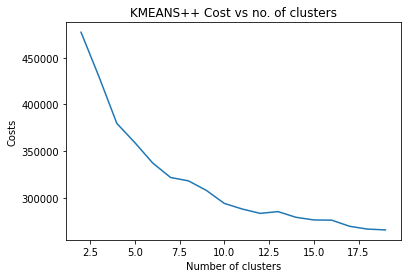

In [ ]:
k = list(range(2,20))
plt.plot(k,costs) 
  
plt.xlabel('Number of clusters') 
plt.ylabel('Costs') 
plt.title('KMEANS++ Cost vs no. of clusters') 
plt.show()

### Applying Elbow method on latent space data using KMEANS++

In [ ]:
#kmeanspp.display_cluster_info()
#kmeanspp.cost()
costs_pp = []
for i in range(2,50):
  print(i)
  kmeanspp = Kmeansplusplus(i)
  kmeanspp.fit(X_train)
  costs_pp.append(kmeanspp.cost())


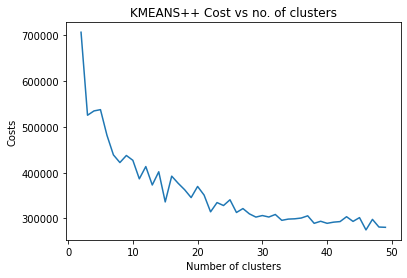

In [ ]:
k = list(range(2,50))
plt.plot(k,costs_pp) 
  
plt.xlabel('Number of clusters') 
plt.ylabel('Costs') 
plt.title('KMEANS++ Cost vs no. of clusters') 
plt.show()